In [ ]:
!pip install torch torchvision gdown pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import shutil
import random
from PIL import Image
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

# CONFIG
GDRIVE_IMAGE_DIR = "/content/drive/MyDrive/images"  # 📂 Road images from Google Drive
NON_ROAD_SAMPLES = 500
ROAD_SAMPLES = 500
TEST_IMAGE_PATH = "./download.jpeg"  # Image to test

# STEP 1: Prepare road images
def prepare_road_dataset():
    print("📦 Preparing road image dataset from Google Drive...")
    os.makedirs("road_subset", exist_ok=True)
    all_images = glob.glob(os.path.join(GDRIVE_IMAGE_DIR, "*.jpg")) + \
                 glob.glob(os.path.join(GDRIVE_IMAGE_DIR, "*.jpeg")) + \
                 glob.glob(os.path.join(GDRIVE_IMAGE_DIR, "*.png"))
    selected = random.sample(all_images, min(ROAD_SAMPLES, len(all_images)))
    for i, img_path in enumerate(selected):
        shutil.copy(img_path, f"road_subset/road_{i}.jpg")
    print(f"✅ Copied {len(os.listdir('road_subset'))} road images.")

def get_dataloaders():
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    print("🔄 Loading CIFAR-10 for non-road images...")
    cifar_data = datasets.CIFAR10(root='.', train=True, download=True)

    class BinaryImageDataset(Dataset):
        def __init__(self, road_folder, cifar_data, transform):
            self.road_paths = [os.path.join(road_folder, f) for f in os.listdir(road_folder)]
            self.cifar_data = cifar_data
            self.transform = transform
            self.samples = [(p, 1) for p in self.road_paths] + [(i, 0) for i in range(NON_ROAD_SAMPLES)]
            random.shuffle(self.samples)

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            data, label = self.samples[idx]
            if label == 1:
                img = Image.open(data).convert("RGB")
            else:
                img, _ = self.cifar_data[data]
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(label, dtype=torch.float32)

    dataset = BinaryImageDataset("road_subset", cifar_data, transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)
    return train_loader, val_loader, transform

# STEP 2: CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# STEP 3: Training
def train_model(model, train_loader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()
    print("🚀 Training model...")
    for epoch in range(10):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(images).squeeze()
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")
    return model

# STEP 4: Evaluation
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = (model(images).squeeze() > 0.5).float()
            correct += (outputs == labels).sum().item()
    acc = 100 * correct / len(val_loader.dataset)
    print(f"✅ Validation Accuracy: {acc:.2f}%")

# STEP 5: Test Uploaded Image
def predict_image(model, transform, device, image_path):
    print(f"\n🖼️ Testing image: {image_path}")
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        conf = model(img_tensor).item()
    print(f"Confidence: {conf:.3f}")
    if conf > 0.5:
        print("✅ Road Image Detected.")
    else:
        print("❌ Not a Road Image.")

# MAIN
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    prepare_road_dataset()
    train_loader, val_loader, transform = get_dataloaders()

    model = SimpleCNN().to(device)
    model = train_model(model, train_loader, device)
    evaluate_model(model, val_loader, device)

    predict_image(model, transform, device, TEST_IMAGE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Preparing road image dataset from Google Drive...
✅ Copied 500 road images.
🔄 Loading CIFAR-10 for non-road images...
🚀 Training model...
Epoch 1 | Loss: 0.5192
Epoch 2 | Loss: 0.2117
Epoch 3 | Loss: 0.1255
Epoch 4 | Loss: 0.0939
Epoch 5 | Loss: 0.0851
Epoch 6 | Loss: 0.0656
Epoch 7 | Loss: 0.0496
Epoch 8 | Loss: 0.0497
Epoch 9 | Loss: 0.0520
Epoch 10 | Loss: 0.0349
✅ Validation Accuracy: 94.50%

🖼️ Testing image: ./download.jpeg
Confidence: 0.001
❌ Not a Road Image.


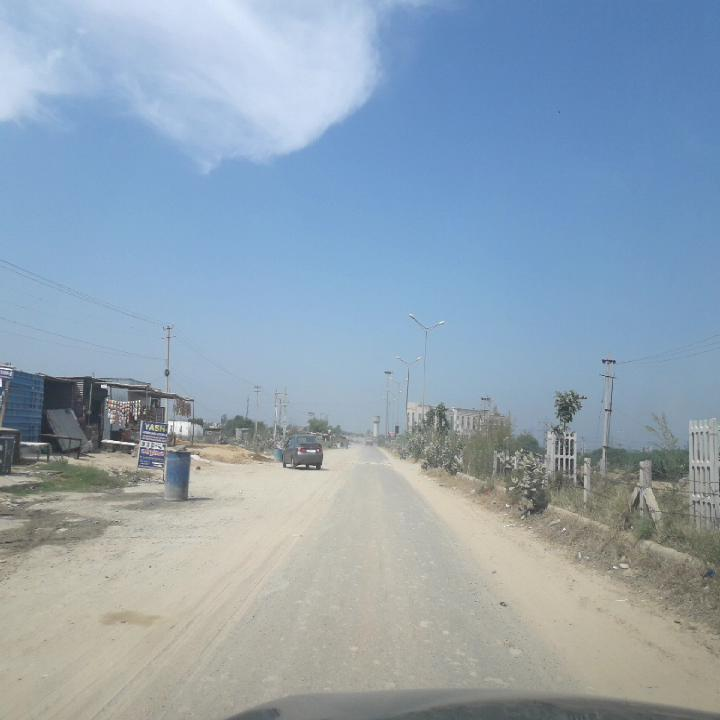

In [4]:
TEST_IMAGE_PATH = "/content/India_000639.jpg"

In [6]:
predict_image(model, transform, device, TEST_IMAGE_PATH)



🖼️ Testing image: /content/India_000639.jpg
Confidence: 0.973
✅ Road Image Detected.


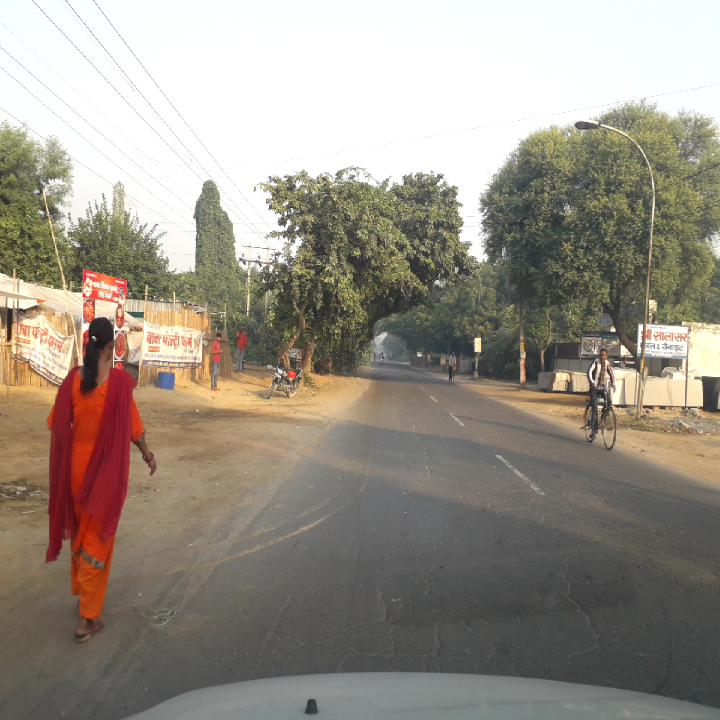

In [7]:
TEST_IMAGE_PATH = "/content/India_000680.jpg"

In [8]:
predict_image(model, transform, device, TEST_IMAGE_PATH)



🖼️ Testing image: /content/India_000680.jpg
Confidence: 1.000
✅ Road Image Detected.


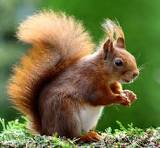

In [9]:
TEST_IMAGE_PATH = "/content/download (1).jpeg"
predict_image(model, transform, device, TEST_IMAGE_PATH)



🖼️ Testing image: /content/download (1).jpeg
Confidence: 0.000
❌ Not a Road Image.


In [10]:
# Save model to Drive
model_save_path = "/content/drive/MyDrive/vit_transformer_models/cnn_road_classifier.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"💾 Model saved to {model_save_path}")


💾 Model saved to /content/drive/MyDrive/vit_transformer_models/cnn_road_classifier.pth
